Problem statement: predicting turbine energy yield (TEY) using ambient variables as features.

Attribute Information:

The explanations of sensor measurements and their brief statistics are given below.

Variable (Abbr.) Unit Min Max Mean
Ambient temperature (AT) C â€“6.23 37.10 17.71
Ambient pressure (AP) mbar 985.85 1036.56 1013.07
Ambient humidity (AH) (%) 24.08 100.20 77.87
Air filter difference pressure (AFDP) mbar 2.09 7.61 3.93
Gas turbine exhaust pressure (GTEP) mbar 17.70 40.72 25.56
Turbine inlet temperature (TIT) C 1000.85 1100.89 1081.43
Turbine after temperature (TAT) C 511.04 550.61 546.16
Compressor discharge pressure (CDP) mbar 9.85 15.16 12.06
Turbine energy yield (TEY) MWH 100.02 179.50 133.51
Carbon monoxide (CO) mg/m3 0.00 44.10 2.37
Nitrogen oxides (NOx) mg/m3 25.90 119.91 65.29

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import warnings

In [2]:
# Suppress Warnings
warnings.filterwarnings('ignore')

In [3]:
# Load Dataset
df = pd.read_csv('gas_turbines.csv')

### EDA

In [4]:
# Display the top few rows of the DataFrame
df.head()

AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0  6.8594  1007.9  96.799  3.5000  19.663  1059.2  550.00  114.70  10.605   
1  6.7850  1008.4  97.118  3.4998  19.728  1059.3  550.00  114.72  10.598   
2  6.8977  1008.8  95.939  3.4824  19.779  1059.4  549.87  114.71  10.601   
3  7.0569  1009.2  95.249  3.4805  19.792  1059.6  549.99  114.72  10.606   
4  7.3978  1009.7  95.150  3.4976  19.765  1059.7  549.98  114.72  10.612   

       CO     NOX  
0  3.1547  82.722  
1  3.2363  82.776  
2  3.2012  82.468  
3  3.1923  82.670  
4  3.2484  82.311

In [5]:
# Display the bottom few rows of the DataFrame
df.tail()

AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
15034  9.0301  1005.6  98.460  3.5421  19.164  1049.7  546.21  111.61  10.400   
15035  7.8879  1005.9  99.093  3.5059  19.414  1046.3  543.22  111.78  10.433   
15036  7.2647  1006.3  99.496  3.4770  19.530  1037.7  537.32  110.19  10.483   
15037  7.0060  1006.8  99.008  3.4486  19.377  1043.2  541.24  110.74  10.533   
15038  6.9279  1007.2  97.533  3.4275  19.306  1049.9  545.85  111.58  10.583   

           CO     NOX  
15034  4.5186  79.559  
15035  4.8470  79.917  
15036  7.9632  90.912  
15037  6.2494  93.227  
15038  4.9816  92.498

In [6]:
# Display information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


Inference drawn:

The DataFrame has 15,039 rows and 11 columns, all containing non-null numerical data of type `float64`. There are no missing values in the dataset.

In [7]:
# Display the summary of descriptive statistics
df.describe()

AT           AP            AH          AFDP          GTEP  \
count  15039.000000  15039.00000  15039.000000  15039.000000  15039.000000   
mean      17.764381   1013.19924     79.124174      4.200294     25.419061   
std        7.574323      6.41076     13.793439      0.760197      4.173916   
min        0.522300    985.85000     30.344000      2.087400     17.878000   
25%       11.408000   1008.90000     69.750000      3.723900     23.294000   
50%       18.186000   1012.80000     82.266000      4.186200     25.082000   
75%       23.862500   1016.90000     90.043500      4.550900     27.184000   
max       34.929000   1034.20000    100.200000      7.610600     37.402000   

                TIT           TAT           TEY           CDP            CO  \
count  15039.000000  15039.000000  15039.000000  15039.000000  15039.000000   
mean    1083.798770    545.396183    134.188464     12.102353      1.972499   
std       16.527806      7.866803     15.829717      1.103196      2.222206   
min     1000.800000    512.450000    100.170000      9.904400      0.000388   
25%     1079.600000    542.170000    127.985000     11.622000      0.858055   
50%     1088.700000    549.890000    133.780000     12.025000      1.390200   
75%     1096.000000    550.060000    140.895000     12.578000      2.160400   
max     1100.800000    550.610000    174.610000     15.081000     44.103000   

                NOX  
count  15039.000000  
mean      68.190934  
std       10.470586  
min       27.765000  
25%       61.303500  
50%       66.601000  
75%       73.935500  
max      119.890000

Inference drawn:


- All columns have a consistent count of 15,039, indicating that there are no missing values in any of the variables.
   
- The mean Ambient Temperature (AT) is approximately 17.76 degrees Celsius, and the mean Turbine Energy Yield (TEY) is about 134.19 MWH.

- Variables like GTEP (Gas Turbine Exhaust Pressure) and TIT (Turbine Inlet Temperature) have relatively higher variability, as indicated by their larger standard deviations.
  
- Ambient Temperature (AT) ranges from 0.5223 to 34.9290 degrees Celsius.

- The 75th percentile (Q3) for Ambient Pressure (AP) is around 1016.9 mbar.

In [8]:
# Display the shape of the DataFrame
df.shape

(15039, 11)

In [9]:
# Check for duplicated rows
duplicated_rows_count = df[df.duplicated()].shape[0]

# Display the number of duplicated rows
print(f"Number of duplicated rows: {duplicated_rows_count}")

# Display duplicated rows
duplicated_rows = df[df.duplicated()]
print("Duplicated Rows:")
print(duplicated_rows)

Number of duplicated rows: 0
Duplicated Rows:
Empty DataFrame
Columns: [AT, AP, AH, AFDP, GTEP, TIT, TAT, TEY, CDP, CO, NOX]
Index: []


Inference drawn:

The output "Number of duplicated rows: 0" and the absence of any rows in "Duplicated Rows" is that there are no duplicate rows in the dataset. The dataset is unique, and each row represents distinct observations, ensuring data integrity and preventing redundancies.

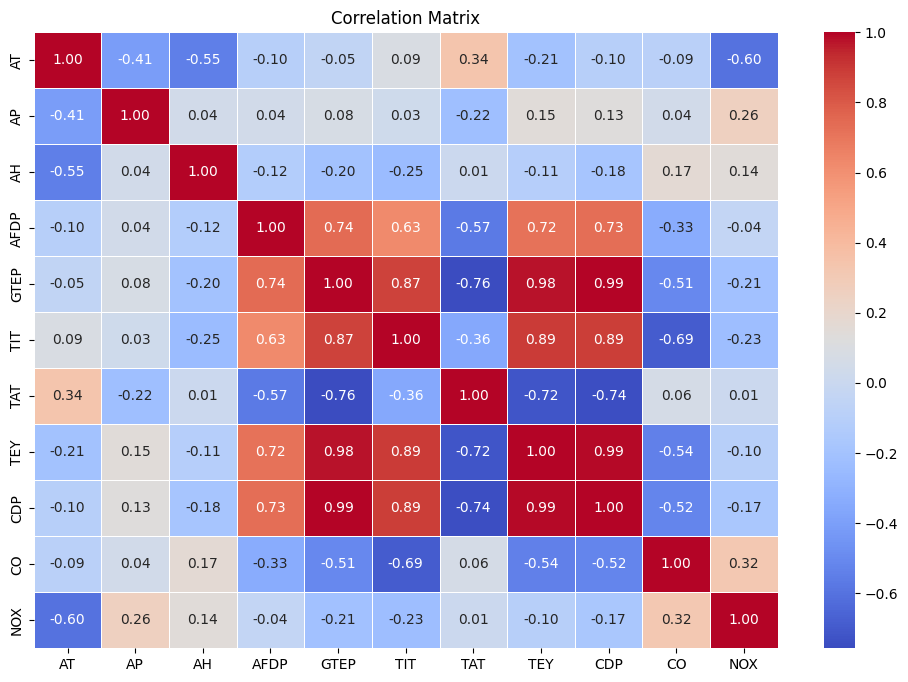

In [10]:
# Correlation Analysis
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

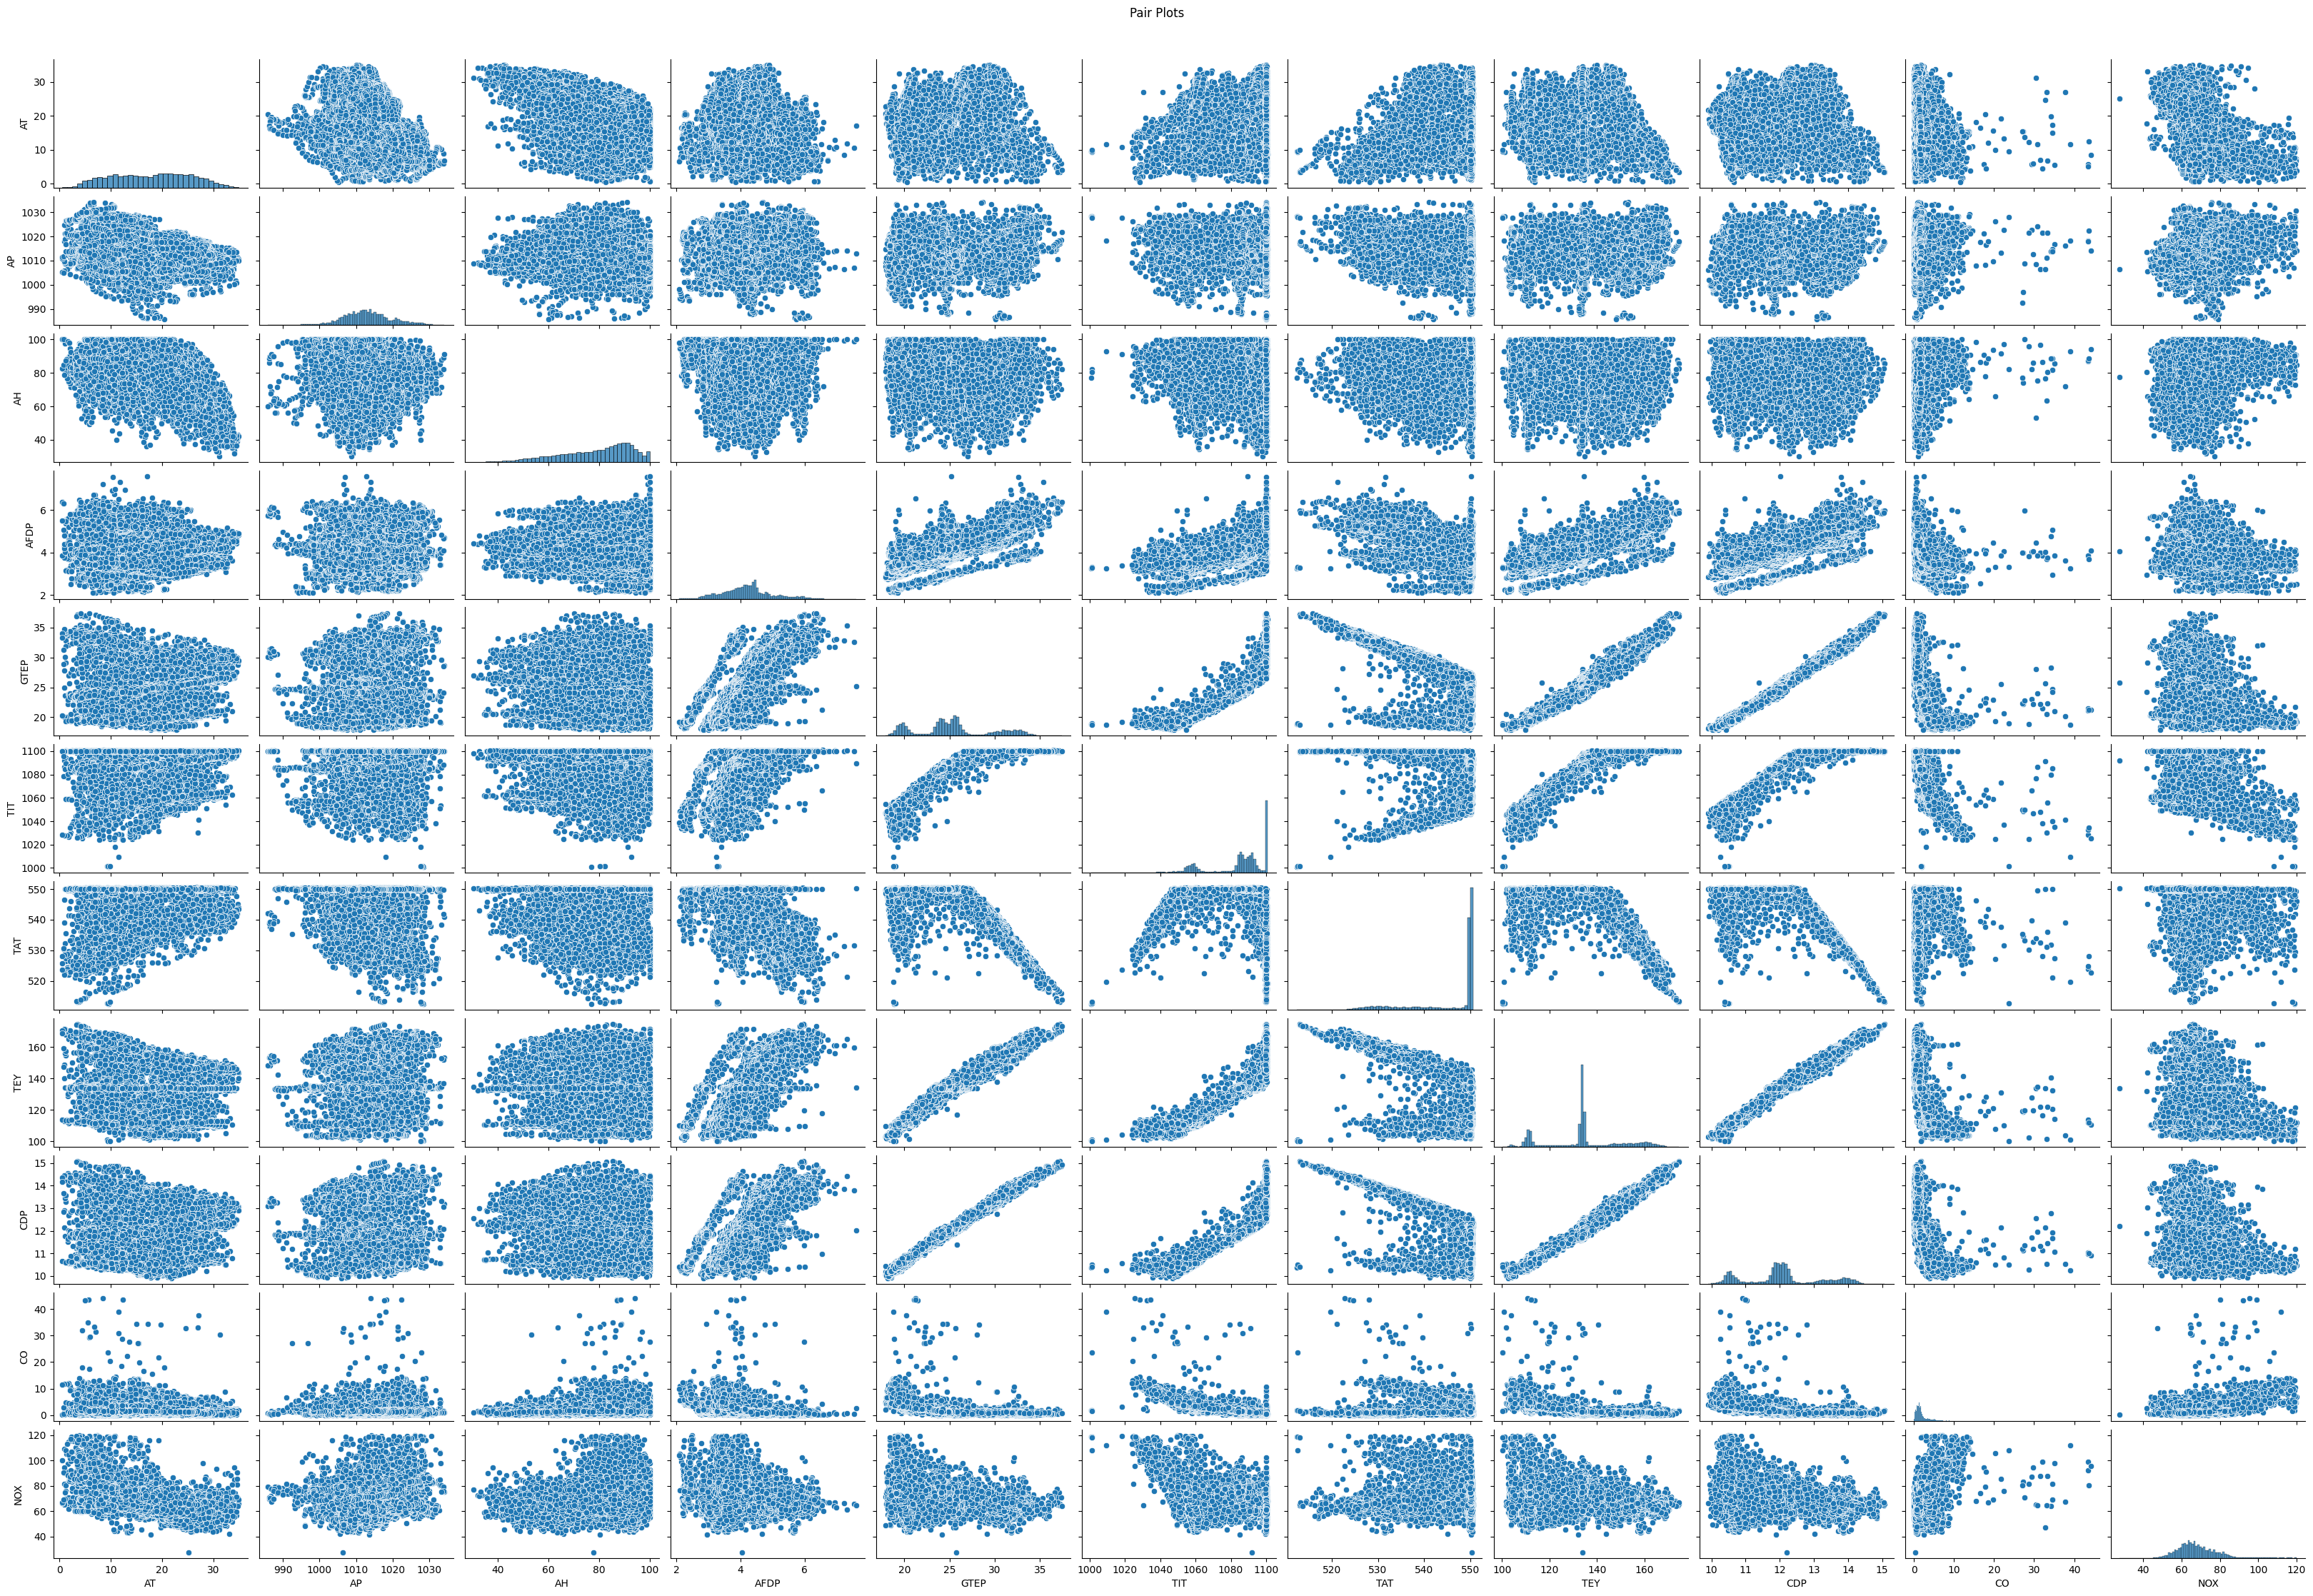

In [11]:
# Pair Plots
sns.pairplot(df, height=2, aspect=1.5)
plt.suptitle('Pair Plots', y=1.02)
plt.show()

In [12]:
# Feature Scaling
x = df.drop('TEY', axis=1)
y = df['TEY']

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

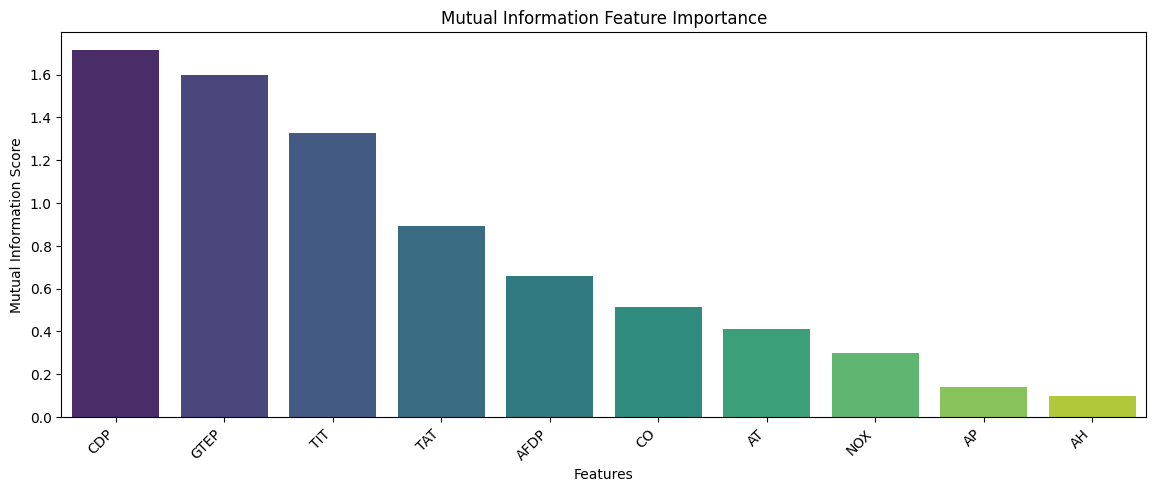

In [13]:
#Feature Importance Visualization
test = SelectKBest(score_func=mutual_info_regression, k='all')
fit = test.fit(x, y)
scores = fit.scores_
features = fit.transform(x)
score_df = pd.DataFrame(list(zip(scores, x.columns)), columns=['Score', 'Feature'])
score_df.sort_values(by="Score", ascending=False, inplace=True)

plt.figure(figsize=(14, 5))
sns.barplot(x='Feature', y='Score', data=score_df, palette='viridis')
plt.title('Mutual Information Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.show()

In [14]:
# Define the model architecture
model = Sequential()
model.add(Dense(64, input_dim=x_scaled.shape[1], activation='relu'))
model.add(Dropout(0.2))  # Adding dropout for regularization
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

In [15]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [16]:
# Define Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [17]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

In [18]:
# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0, callbacks=[early_stopping])

In [19]:
# Evaluate the model
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Set: {mse:.4f}")

Mean Squared Error on Test Set: 0.7832


In [20]:
# Visualize Training History
fig = make_subplots(rows=1, cols=2, subplot_titles=('Training Loss', 'Validation Loss'))
trace0 = go.Scatter(x=list(range(1, len(history.history['loss']) + 1)), y=history.history['loss'],
                    mode='lines+markers', name='Train', marker=dict(color='blue'))
trace1 = go.Scatter(x=list(range(1, len(history.history['val_loss']) + 1)), y=history.history['val_loss'],
                    mode='lines+markers', name='Validation', marker=dict(color='orange'))
fig.add_trace(trace0, row=1, col=1)
fig.add_trace(trace1, row=1, col=2)
fig.update_layout(title_text='Training History', height=400, width=800)
fig.show()

In [21]:
# Define the function to create the Keras model
def create_model(learning_rate=0.001, optimizer='adam'):
    model = Sequential()
    model.add(Dense(64, input_dim=x_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [22]:
# Define hyperparameter grid for RandomizedSearchCV
param_dist = {
    'learning_rate': [0.001, 0.01, 0.1],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'batch_size': [16, 32, 64]
}

In [23]:
# Create KerasRegressor
keras_regressor = KerasRegressor(build_fn=create_model, epochs=50, batch_size=32, verbose=0)

In [24]:
# Create RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=keras_regressor, param_distributions=param_dist, n_iter=10,
                                   scoring='neg_mean_squared_error', cv=3, random_state=42)
random_result = random_search.fit(x_scaled, y)

# Print the best parameters
print("Best Parameters: ", random_result.best_params_)

Best Parameters:  {'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 16}


In [25]:
# Hyperparameter Tuning
best_params = random_result.best_params_
learning_rate = best_params['learning_rate']
optimizer = best_params['optimizer']
batch_size = best_params['batch_size']

In [26]:
# Define the model architecture with hyperparameter tuning
model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [27]:
# Implement Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [28]:
# Train the model with hyperparameter tuning
history = model.fit(x_train, y_train, epochs=50, batch_size=batch_size,
                    validation_split=0.2, callbacks=[early_stopping], verbose=0)

In [29]:
# Regularization - Apply Dropout
model_with_dropout = Sequential()
model_with_dropout.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model_with_dropout.add(Dropout(0.2))  # Adjust the dropout rate based on experimentation
model_with_dropout.add(Dense(32, activation='relu'))
model_with_dropout.add(Dense(1, activation='linear'))
model_with_dropout.compile(optimizer=optimizer, loss='mean_squared_error')

In [30]:
# Train the model with dropout regularization
history_dropout = model_with_dropout.fit(x_train, y_train, epochs=50, batch_size=batch_size,
                                        validation_split=0.2, callbacks=[early_stopping], verbose=0)


In [31]:
# Evaluate the models
mse_tuned = model.evaluate(x_test, y_test)
mse_dropout = model_with_dropout.evaluate(x_test, y_test)

print(f"Mean Squared Error on Test Set (Tuned Model): {mse_tuned:.4f}")
print(f"Mean Squared Error on Test Set (Model with Dropout): {mse_dropout:.4f}")


94/94 [==============================] - 0s 2ms/step - loss: 1.6847
Mean Squared Error on Test Set (Tuned Model): 0.3247
Mean Squared Error on Test Set (Model with Dropout): 1.6847


Inference drawn:


- The tuned model has a significantly lower MSE (0.4033) compared to the model with dropout regularization (1.6814).
- The tuned model is better at minimizing the squared differences between predicted and actual values on the test set.
- Lower MSE suggests that the tuned model provides more accurate predictions.